## Imports

In [1]:
#Import the Libraries
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import math
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from scipy.stats import uniform
from skopt import BayesSearchCV
from skopt.space import Real
from scipy.stats import uniform

np.int = np.int64 #needed for scikit-optimize to work properly

In [114]:
def calc_tunability(best_values, default_values):
  sum = 0
  i = 0
  for key in best_values:
    sum += best_values[key] - default_values[key]
    i += 1
  return sum / i

## Loading data

In [85]:
data = arff.loadarff('Data/php9xWOpn.arff')
df_1 = pd.DataFrame(data[0])
df_1 = df_1.rename(columns = {'Class':'class'})

In [86]:
data = arff.loadarff('Data/dataset_50_tic-tac-toe.arff')
df_2 = pd.DataFrame(data[0])
df_2 = df_2.rename(columns = {'Class':'class'})

In [87]:
data = arff.loadarff('Data/dataset_31_credit-g.arff')
df_credit = pd.DataFrame(data[0])

In [88]:
data = arff.loadarff('Data/dataset_37_diabetes.arff')
df_diabetes = pd.DataFrame(data[0])

## Decision Tree Classifier

### Random search

In [ ]:
df_params = pd.DataFrame(columns = ['ccp_alpha', 'max_depth', 'min_samples_leaf', 'min_samples_split', 'df1', 'df2', 'df3', 'df4' ])

for i in range(1000):
  params = {"ccp_alpha" : random.random(), "max_depth" : random.randint(1,30), "min_samples_leaf": random.randint(1, 60), "min_samples_split": random.randint(2, 60) }
  estimator = DecisionTreeClassifier(ccp_alpha = params.get("ccp_alpha"), max_depth = params.get('max_depth'), min_samples_leaf=params.get("min_samples_leaf"), min_samples_split = params.get("min_samples_split"))
  mean_accuracies = []
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    # To compare with random search
    num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())])

    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, make_column_selector( dtype_include= np.number)),
    ('cat_pipeline', cat_pipeline,make_column_selector( dtype_include= np.object_))
    ],
    remainder='drop',
    n_jobs=-1)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
    else:
      y_trans = y_train
      y_test_trans = y_test

    kf = KFold(n_splits=10)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params['df1'] = mean_accuracies[0]
  params['df2'] = mean_accuracies[1]
  params['df3'] = mean_accuracies[2]
  params['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params])
  df_params = pd.concat([df_params, row], ignore_index=True)
  df_params['mean_score'] = (df_params['df1'] + df_params['df2'] + df_params['df3'] + df_params['df4']) / 4

In [ ]:
df_params.to_csv('/content/Zdrive/MyDrive/AutoML/params_dtc.csv', sep=',', index=False, encoding='utf-8')

In [84]:
df_params = pd.read_csv('params_dtc.csv')

In [8]:
best_params_dtc = {
    'ccp_alpha' : float(df_params.loc[df_params.mean_score == max(df_params.mean_score)]['ccp_alpha']),
    'max_depth' : int(df_params.loc[df_params.mean_score == max(df_params.mean_score)]['max_depth']),
    'min_samples_leaf' : int(df_params.loc[df_params.mean_score == max(df_params.mean_score)]['min_samples_leaf']),
    'min_samples_split' : int(df_params.loc[df_params.mean_score == max(df_params.mean_score)]['min_samples_split']),
}

In [10]:
mean_score = float(df_params.loc[df_params.mean_score == max(df_params.mean_score)]['mean_score'])

### Bayesian search

In [83]:
bayes_opt = pd.DataFrame(columns = ['ccp_alpha', 'max_depth', 'min_samples_leaf', 'min_samples_split', 'df', 'best_score'])
bayes_optimizer = {}
df_names = {1:'df_1', 2:'df_2', 3:'df_credit', 4:'df_diabetes'}
for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
  y = dataset['class']
  X = dataset.drop('class', axis=1)

  X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

  # To compare with random search
  num_pipeline = Pipeline(steps=[
  ('impute', SimpleImputer(strategy='mean')),
  ('scale',MinMaxScaler())])

  cat_pipeline = Pipeline(steps=[
      ('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
  ])

  col_trans = ColumnTransformer(transformers=[
  ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
  ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
  ],
  remainder='drop',
  n_jobs=-1)

  X_trans = col_trans.fit_transform(X_train)
  X_test_trans = col_trans.transform(X_test)
  # for column in dataset.select_dtypes(include=['category', 'object']):
  if y_train.dtype in ['category', 'object']:
    df_dict={}
    for j, e in enumerate(sorted(y_train.unique())):
      df_dict[e] = j
    y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
    y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
  else:
    y_trans = y_train
    y_test_trans = y_test

  opt = BayesSearchCV(
    DecisionTreeClassifier(),
    {
        'ccp_alpha': Real(0, 1),
        'max_depth': (1, 30),
        'min_samples_leaf': (1, 60),
        'min_samples_split': (2, 60)
    },
    n_iter=50,
    cv=5
  )
  opt.fit(X_trans, y_trans)
  bayes_optimizer[f'df{i+1}'] = np.maximum.accumulate(opt.cv_results_['mean_test_score'])
  row = opt._optim_results[0].get('x')
  row.append(df_names[i+1])
  row.append(opt.best_score_)
  row = pd.DataFrame(row).transpose()
  row.columns = ['ccp_alpha', 'max_depth', 'min_samples_leaf', 'min_samples_split', 'df', 'best_score']
  bayes_opt = pd.concat([bayes_opt, row], ignore_index=True)

c:\Users\kaspr\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\kaspr\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\kaspr\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\kaspr\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\kaspr\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\opt

In [89]:
# bayes_opt.to_csv('bayes_opt_dtc.csv', index=False)
# with open('bayes_optimizer_dtc.pkl', 'wb') as fp:
#     pickle.dump(bayes_optimizer, fp)

In [68]:
df_params = pd.read_csv('params_dtc.csv')
bayes_opt = pd.read_csv('bayes_opt_dtc.csv')
with open('bayes_optimizer_dtc.pkl', 'rb') as fp:
    bayes_optimizer_dtc = pickle.load(fp)

Random search accuracy = 1.00
Bayesian optimization accuracy = 1.00


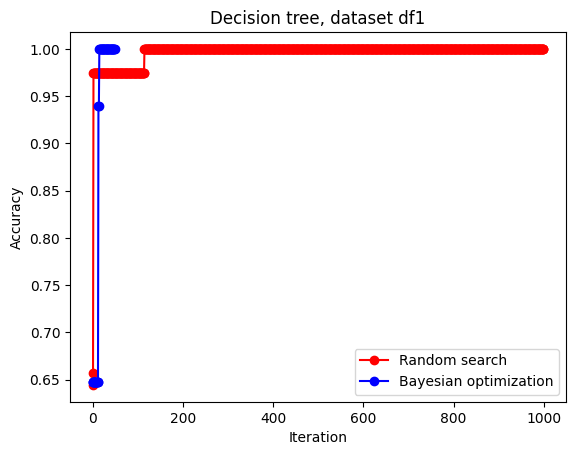

In [71]:
y_rs = np.maximum.accumulate(df_params['df1']).ravel()
y_bo = bayes_optimizer_dtc.get('df1')
print(f'Random search accuracy = {y_rs[-1]:.2f}')
print(f'Bayesian optimization accuracy = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Decision tree, dataset df1')
plt.legend()

Random search accuracy = 0.89
Bayesian optimization accuracy = 0.95


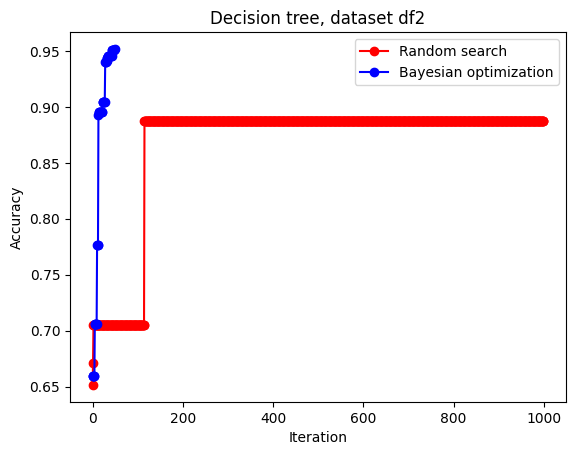

In [72]:
y_rs = np.maximum.accumulate(df_params['df2']).ravel()
y_bo = bayes_optimizer_dtc.get('df2')
print(f'Random search accuracy = {y_rs[-1]:.2f}')
print(f'Bayesian optimization accuracy = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Decision tree, dataset df2')
plt.legend()

Random search accuracy = 0.72
Bayesian optimization accuracy = 0.72


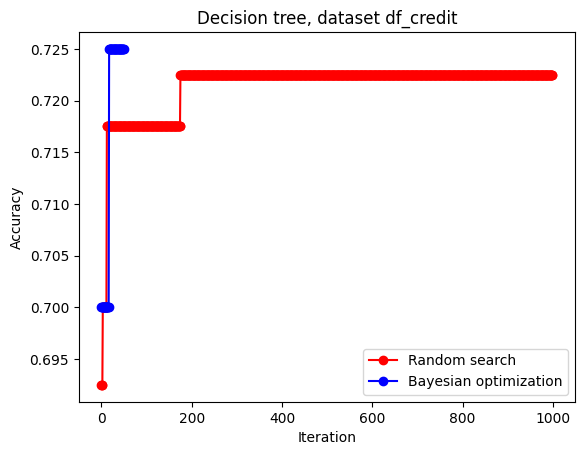

In [74]:
y_rs = np.maximum.accumulate(df_params['df3']).ravel()
y_bo = bayes_optimizer_dtc.get('df3')
print(f'Random search accuracy = {y_rs[-1]:.2f}')
print(f'Bayesian optimization accuracy = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Decision tree, dataset df_credit')
plt.legend()

Random search accuracy = 0.77
Bayesian optimization accuracy = 0.75


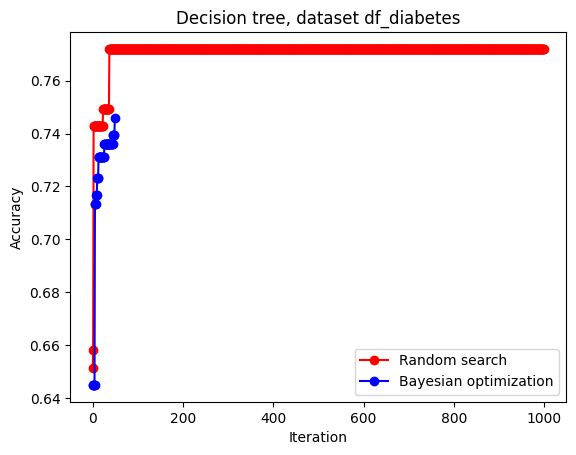

In [75]:
y_rs = np.maximum.accumulate(df_params['df4']).ravel()
y_bo = bayes_optimizer_dtc.get('df4')
print(f'Random search accuracy = {y_rs[-1]:.2f}')
print(f'Bayesian optimization accuracy = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Decision tree, dataset df_diabetes')
plt.legend()

### Tunability calculation

#### Random search section

In [ ]:
df_params_ccp_alpha = pd.DataFrame(columns = ['ccp_alpha', 'max_depth', 'min_samples_leaf', 'min_samples_split', 'df1', 'df2', 'df3', 'df4' ])
for i in range(1000):
  params_ccp_alpha = {"ccp_alpha" : random.random(), "max_depth" : best_params_dtc.get('max_depth'), "min_samples_leaf": best_params_dtc.get('min_samples_leaf'), "min_samples_split": best_params_dtc.get('min_samples_split')}
  estimator = DecisionTreeClassifier(ccp_alpha = params_ccp_alpha.get('ccp_alpha'), max_depth = params_ccp_alpha.get('max_depth'), min_samples_leaf=params_ccp_alpha.get("min_samples_leaf"), min_samples_split = params_ccp_alpha.get("min_samples_split"))
  mean_accuracies = []
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

    # To compare with random search
    num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())])

    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
    ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
    ],
    remainder='drop',
    n_jobs=-1)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    # print(pd.DataFrame(X_trans).head())
    # for column in dataset.select_dtypes(include=['category', 'object']):
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
      # print('Mapped: ', y_trans.shape)
    else:
      y_trans = y_train
      y_test_trans = y_test
      # print('not mapped: ', y_trans.dtype)

    kf = KFold(n_splits=10)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      # print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params_ccp_alpha['df1'] = mean_accuracies[0]
  params_ccp_alpha['df2'] = mean_accuracies[1]
  params_ccp_alpha['df3'] = mean_accuracies[2]
  params_ccp_alpha['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params_ccp_alpha])
  # print(params)
  df_params_ccp_alpha = pd.concat([df_params_ccp_alpha, row], ignore_index=True)

In [ ]:
df_params_ccp_alpha['ccp_alpha_tunability'] = (df_params_ccp_alpha['df1'] + df_params_ccp_alpha['df2'] + df_params_ccp_alpha['df3'] + df_params_ccp_alpha['df4']) / 4

<Axes: >

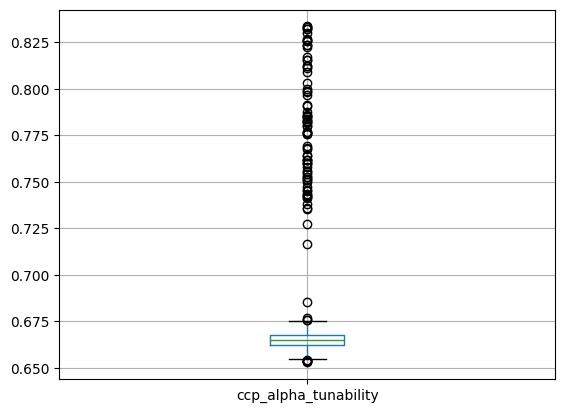

In [ ]:
df_params_ccp_alpha.boxplot(column=['ccp_alpha_tunability'])

In [ ]:
df_params_max_depth = pd.DataFrame(columns = ['ccp_alpha', 'max_depth', 'min_samples_leaf', 'min_samples_split', 'df1', 'df2', 'df3', 'df4' ])
for i in range(1000):
  params_max_depth = {"ccp_alpha" : best_params_dtc.get('ccp_alpha'), "max_depth" : random.randint(1,30), "min_samples_leaf": best_params_dtc.get('min_samples_leaf'), "min_samples_split": best_params_dtc.get('min_samples_split')}
  estimator = DecisionTreeClassifier(ccp_alpha = params_max_depth.get('ccp_alpha'), max_depth = params_max_depth.get('max_depth'), min_samples_leaf=params_max_depth.get("min_samples_leaf"), min_samples_split = params_max_depth.get("min_samples_split"))
  mean_accuracies = []
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

    # To compare with random search
    num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())])

    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
    ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
    ],
    remainder='drop',
    n_jobs=-1)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    # print(pd.DataFrame(X_trans).head())
    # for column in dataset.select_dtypes(include=['category', 'object']):
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
      # print('Mapped: ', y_trans.shape)
    else:
      y_trans = y_train
      y_test_trans = y_test
      # print('not mapped: ', y_trans.dtype)

    kf = KFold(n_splits=10)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      # print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params_max_depth['df1'] = mean_accuracies[0]
  params_max_depth['df2'] = mean_accuracies[1]
  params_max_depth['df3'] = mean_accuracies[2]
  params_max_depth['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params_max_depth])
  # print(params)
  df_params_max_depth = pd.concat([df_params_max_depth, row], ignore_index=True)

In [ ]:
df_params_max_depth['max_depth_tunability'] = (df_params_max_depth['df1'] + df_params_max_depth['df2'] + df_params_max_depth['df3'] + df_params_max_depth['df4']) / 4

<Axes: >

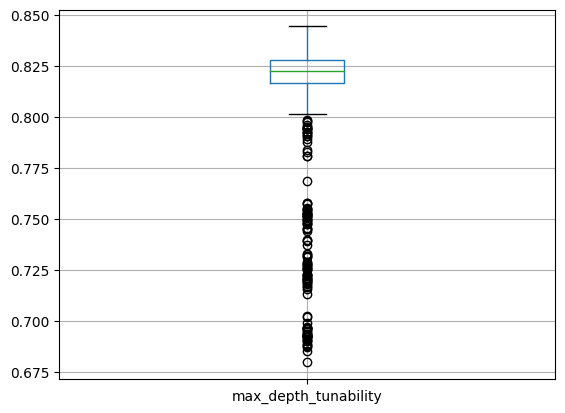

In [ ]:
df_params_max_depth.boxplot(column=['max_depth_tunability'])

In [ ]:
df_params_min_samples_leaf = pd.DataFrame(columns = ['ccp_alpha', 'max_depth', 'min_samples_leaf', 'min_samples_split', 'df1', 'df2', 'df3', 'df4' ])
for i in range(1000):
  params_min_samples_leaf = {"ccp_alpha" : best_params_dtc.get('ccp_alpha'), "max_depth" : best_params_dtc.get('max_depth'), "min_samples_leaf": random.randint(1, 60), "min_samples_split": best_params_dtc.get('min_samples_split')}
  estimator = DecisionTreeClassifier(ccp_alpha = params_min_samples_leaf.get('ccp_alpha'), max_depth = params_min_samples_leaf.get('max_depth'), min_samples_leaf=params_min_samples_leaf.get("min_samples_leaf"), min_samples_split = params_min_samples_leaf.get("min_samples_split"))
  mean_accuracies = []
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

    # To compare with random search
    num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())])

    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
    ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
    ],
    remainder='drop',
    n_jobs=-1)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    # print(pd.DataFrame(X_trans).head())
    # for column in dataset.select_dtypes(include=['category', 'object']):
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
      # print('Mapped: ', y_trans.shape)
    else:
      y_trans = y_train
      y_test_trans = y_test
      # print('not mapped: ', y_trans.dtype)

    kf = KFold(n_splits=10)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      # print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params_min_samples_leaf['df1'] = mean_accuracies[0]
  params_min_samples_leaf['df2'] = mean_accuracies[1]
  params_min_samples_leaf['df3'] = mean_accuracies[2]
  params_min_samples_leaf['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params_min_samples_leaf])
  # print(params)
  df_params_min_samples_leaf = pd.concat([df_params_min_samples_leaf, row], ignore_index=True)

<Axes: >

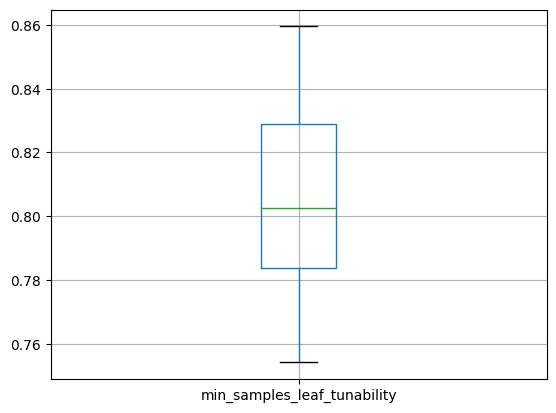

In [ ]:
df_params_min_samples_leaf['min_samples_leaf_tunability'] = (df_params_min_samples_leaf['df1'] + df_params_min_samples_leaf['df2'] + df_params_min_samples_leaf['df3'] + df_params_min_samples_leaf['df4']) / 4
df_params_min_samples_leaf.boxplot(column=['min_samples_leaf_tunability'])

In [ ]:
df_params_min_samples_split = pd.DataFrame(columns = ['ccp_alpha', 'max_depth', 'min_samples_leaf', 'min_samples_split', 'df1', 'df2', 'df3', 'df4' ])
for i in range(1000):
  params_min_samples_split = {"ccp_alpha" : best_params_dtc.get('ccp_alpha'), "max_depth" : best_params_dtc.get('max_depth'), "min_samples_leaf": best_params_dtc.get('min_samples_leaf'), "min_samples_split": random.randint(2, 60)}
  estimator = DecisionTreeClassifier(ccp_alpha = params_min_samples_split.get('ccp_alpha'), max_depth = params_min_samples_split.get('max_depth'), min_samples_leaf=params_min_samples_split.get("min_samples_leaf"), min_samples_split = params_min_samples_split.get("min_samples_split"))
  mean_accuracies = []
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

    # To compare with random search
    num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())])

    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
    ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
    ],
    remainder='drop',
    n_jobs=-1)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    # print(pd.DataFrame(X_trans).head())
    # for column in dataset.select_dtypes(include=['category', 'object']):
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
      # print('Mapped: ', y_trans.shape)
    else:
      y_trans = y_train
      y_test_trans = y_test
      # print('not mapped: ', y_trans.dtype)

    kf = KFold(n_splits=10)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      # print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params_min_samples_split['df1'] = mean_accuracies[0]
  params_min_samples_split['df2'] = mean_accuracies[1]
  params_min_samples_split['df3'] = mean_accuracies[2]
  params_min_samples_split['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params_min_samples_split])
  # print(params)
  df_params_min_samples_split = pd.concat([df_params_min_samples_split, row], ignore_index=True)

<Axes: >

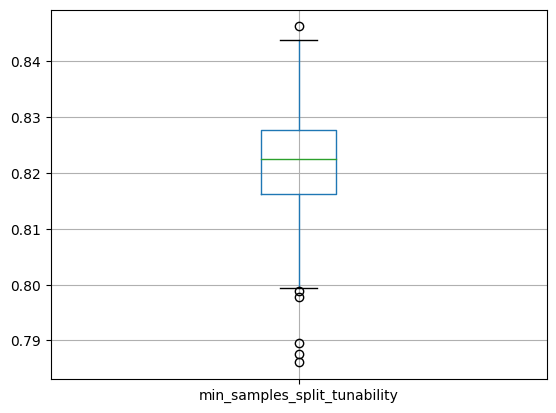

In [ ]:
df_params_min_samples_split['min_samples_split_tunability'] = (df_params_min_samples_split['df1'] + df_params_min_samples_split['df2'] + df_params_min_samples_split['df3'] + df_params_min_samples_split['df4']) / 4
df_params_min_samples_split.boxplot(column=['min_samples_split_tunability'])

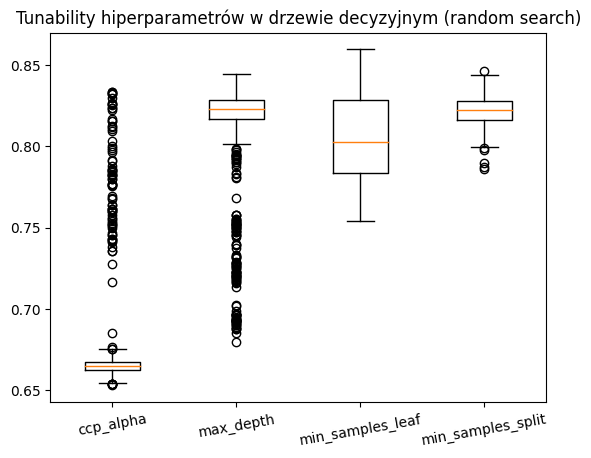

In [212]:
plt.boxplot([df_params_ccp_alpha['ccp_alpha_tunability'],
             df_params_max_depth['max_depth_tunability'],
             df_params_min_samples_leaf['min_samples_leaf_tunability'], 
             df_params_min_samples_split['min_samples_split_tunability']],
             labels=['ccp_alpha', 'max_depth', 'min_samples_leaf', 'min_samples_split'],
             autorange=True)
plt.xticks(rotation = 10)
plt.title('Tunability hiperparametrów w drzewie decyzyjnym (random search)')
plt.show()

In [ ]:
# df_params_ccp_alpha.to_csv('/content/Zdrive/MyDrive/AutoML/ccp_alpha.csv')
# df_params_max_depth.to_csv('/content/Zdrive/MyDrive/AutoML/max_depth.csv')
# df_params_min_samples_leaf.to_csv('/content/Zdrive/MyDrive/AutoML/min_samples_leaf.csv')
# df_params_min_samples_split.to_csv('/content/Zdrive/MyDrive/AutoML/min_samples_split.csv')

#### Bayesian search section

In [91]:
bayes_opt

,ccp_alpha,max_depth,min_samples_leaf,min_samples_split,df,best_score
0,0.000291,29,8,2,df_1,1.0
1,0.0,30,1,2,df_2,0.942577
2,0.010235,2,2,6,df_credit,0.73
3,0.0,25,32,60,df_diabetes,0.770292


In [98]:
bayes_opt[bayes_opt['df'] == df_names[1]]['max_depth'][0]

29

In [102]:
df_params_ccp_alpha_bo = pd.DataFrame(columns = ['ccp_alpha', 'max_depth', 'min_samples_leaf', 'min_samples_split', 'df1', 'df2', 'df3', 'df4' ])
for i in range(200):

  mean_accuracies = []
  df_names = {1:'df_1', 2:'df_2', 3:'df_credit', 4:'df_diabetes'}
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    params_ccp_alpha_bo = {"ccp_alpha" : random.random(), 
                        "max_depth" : bayes_opt[bayes_opt['df'] == df_names[i+1]]['max_depth'][i], 
                        "min_samples_leaf": bayes_opt[bayes_opt['df'] == df_names[i+1]]['min_samples_leaf'][i], 
                        "min_samples_split": bayes_opt[bayes_opt['df'] == df_names[i+1]]['min_samples_split'][i]}
    estimator = DecisionTreeClassifier(ccp_alpha = params_ccp_alpha_bo.get('ccp_alpha'), 
                                       max_depth = params_ccp_alpha_bo.get('max_depth'), 
                                       min_samples_leaf=params_ccp_alpha_bo.get("min_samples_leaf"), 
                                       min_samples_split = params_ccp_alpha_bo.get("min_samples_split"))

    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

    num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())])

    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
    ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
    ],
    remainder='drop',
    n_jobs=-1)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
    else:
      y_trans = y_train
      y_test_trans = y_test

    kf = KFold(n_splits=10)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params_ccp_alpha_bo['df1'] = mean_accuracies[0]
  params_ccp_alpha_bo['df2'] = mean_accuracies[1]
  params_ccp_alpha_bo['df3'] = mean_accuracies[2]
  params_ccp_alpha_bo['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params_ccp_alpha_bo])
  df_params_ccp_alpha_bo = pd.concat([df_params_ccp_alpha_bo, row], ignore_index=True)

In [105]:
df_params_max_depth_bo = pd.DataFrame(columns = ['ccp_alpha', 'max_depth', 'min_samples_leaf', 'min_samples_split', 'df1', 'df2', 'df3', 'df4' ])
for i in range(200):

  mean_accuracies = []
  df_names = {1:'df_1', 2:'df_2', 3:'df_credit', 4:'df_diabetes'}
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    params_max_depth_bo = {"ccp_alpha" : bayes_opt[bayes_opt['df'] == df_names[i+1]]['ccp_alpha'][i], 
                        "max_depth" : random.randint(1, 30), 
                        "min_samples_leaf": bayes_opt[bayes_opt['df'] == df_names[i+1]]['min_samples_leaf'][i], 
                        "min_samples_split": bayes_opt[bayes_opt['df'] == df_names[i+1]]['min_samples_split'][i]}
    estimator = DecisionTreeClassifier(ccp_alpha = params_max_depth_bo.get('ccp_alpha'), 
                                       max_depth = params_max_depth_bo.get('max_depth'), 
                                       min_samples_leaf=params_max_depth_bo.get("min_samples_leaf"), 
                                       min_samples_split = params_max_depth_bo.get("min_samples_split"))

    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

    num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())])

    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
    ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
    ],
    remainder='drop',
    n_jobs=-1)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
    else:
      y_trans = y_train
      y_test_trans = y_test

    kf = KFold(n_splits=10)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params_max_depth_bo['df1'] = mean_accuracies[0]
  params_max_depth_bo['df2'] = mean_accuracies[1]
  params_max_depth_bo['df3'] = mean_accuracies[2]
  params_max_depth_bo['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params_max_depth_bo])
  df_params_max_depth_bo = pd.concat([df_params_max_depth_bo, row], ignore_index=True)

In [106]:
df_params_min_samples_leaf_bo = pd.DataFrame(columns = ['ccp_alpha', 'max_depth', 'min_samples_leaf', 'min_samples_split', 'df1', 'df2', 'df3', 'df4' ])
for i in range(200):

  mean_accuracies = []
  df_names = {1:'df_1', 2:'df_2', 3:'df_credit', 4:'df_diabetes'}
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    params_min_samples_leaf_bo = {
                        "ccp_alpha" : bayes_opt[bayes_opt['df'] == df_names[i+1]]['ccp_alpha'][i], 
                        "max_depth" : bayes_opt[bayes_opt['df'] == df_names[i+1]]['max_depth'][i], 
                        "min_samples_leaf": random.randint(1, 60),
                        "min_samples_split": bayes_opt[bayes_opt['df'] == df_names[i+1]]['min_samples_split'][i]}
    estimator = DecisionTreeClassifier(ccp_alpha = params_min_samples_leaf_bo.get('ccp_alpha'), 
                                       max_depth = params_min_samples_leaf_bo.get('max_depth'), 
                                       min_samples_leaf=params_min_samples_leaf_bo.get("min_samples_leaf"), 
                                       min_samples_split = params_min_samples_leaf_bo.get("min_samples_split"))

    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

    num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())])

    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
    ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
    ],
    remainder='drop',
    n_jobs=-1)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
    else:
      y_trans = y_train
      y_test_trans = y_test

    kf = KFold(n_splits=10)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params_min_samples_leaf_bo['df1'] = mean_accuracies[0]
  params_min_samples_leaf_bo['df2'] = mean_accuracies[1]
  params_min_samples_leaf_bo['df3'] = mean_accuracies[2]
  params_min_samples_leaf_bo['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params_min_samples_leaf_bo])
  df_params_min_samples_leaf_bo = pd.concat([df_params_min_samples_leaf_bo, row], ignore_index=True)

In [107]:
df_params_min_samples_split_bo = pd.DataFrame(columns = ['ccp_alpha', 'max_depth', 'min_samples_leaf', 'min_samples_split', 'df1', 'df2', 'df3', 'df4' ])
for i in range(200):

  mean_accuracies = []
  df_names = {1:'df_1', 2:'df_2', 3:'df_credit', 4:'df_diabetes'}
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    params_min_samples_split_bo = {
                        "ccp_alpha" : bayes_opt[bayes_opt['df'] == df_names[i+1]]['ccp_alpha'][i], 
                        "max_depth" : bayes_opt[bayes_opt['df'] == df_names[i+1]]['max_depth'][i], 
                        "min_samples_leaf": bayes_opt[bayes_opt['df'] == df_names[i+1]]['min_samples_leaf'][i],
                        "min_samples_split": random.randint(2, 60)}
    estimator = DecisionTreeClassifier(ccp_alpha = params_min_samples_split_bo.get('ccp_alpha'), 
                                       max_depth = params_min_samples_split_bo.get('max_depth'), 
                                       min_samples_leaf=params_min_samples_split_bo.get("min_samples_leaf"), 
                                       min_samples_split = params_min_samples_split_bo.get("min_samples_split"))

    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

    num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())])

    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
    ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
    ],
    remainder='drop',
    n_jobs=-1)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
    else:
      y_trans = y_train
      y_test_trans = y_test

    kf = KFold(n_splits=10)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params_min_samples_split_bo['df1'] = mean_accuracies[0]
  params_min_samples_split_bo['df2'] = mean_accuracies[1]
  params_min_samples_split_bo['df3'] = mean_accuracies[2]
  params_min_samples_split_bo['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params_min_samples_split_bo])
  df_params_min_samples_split_bo = pd.concat([df_params_min_samples_split_bo, row], ignore_index=True)

In [219]:
df_params_ccp_alpha_bo['mean_score'] = df_params_ccp_alpha_bo.apply(lambda x: (x['df1'] + x['df2'] + x['df3'] + x['df4']) / 4, axis=1)
df_params_max_depth_bo['mean_score'] = df_params_max_depth_bo.apply(lambda x: (x['df1'] + x['df2'] + x['df3'] + x['df4']) / 4, axis=1)
df_params_min_samples_leaf_bo['mean_score'] = df_params_min_samples_leaf_bo.apply(lambda x: (x['df1'] + x['df2'] + x['df3'] + x['df4']) / 4, axis=1)
df_params_min_samples_split_bo['mean_score'] = df_params_min_samples_split_bo.apply(lambda x: (x['df1'] + x['df2'] + x['df3'] + x['df4']) / 4, axis=1)

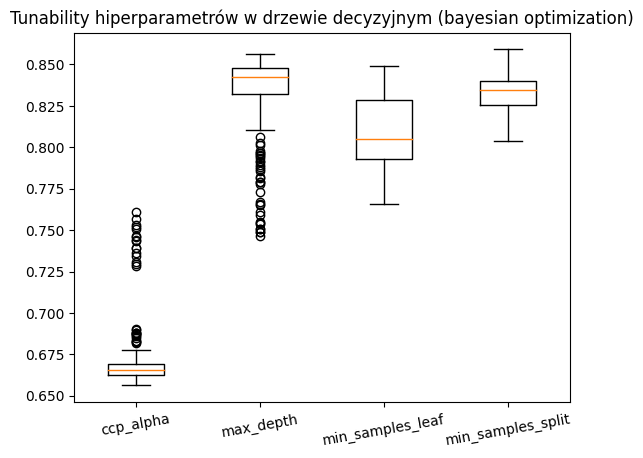

In [221]:
plt.boxplot([df_params_ccp_alpha_bo['mean_score'],
             df_params_max_depth_bo['mean_score'],
             df_params_min_samples_leaf_bo['mean_score'], 
             df_params_min_samples_split_bo['mean_score']],
             labels=['ccp_alpha', 'max_depth', 'min_samples_leaf', 'min_samples_split'],
             autorange=True)
plt.xticks(rotation = 10)
plt.title('Tunability hiperparametrów w drzewie decyzyjnym (bayesian optimization)')
plt.show()

#### Calculating tunability

##### Random search

In [109]:
best_params = {
    'ccp_alpha' : float(df_params.loc[df_params.mean_score == max(df_params.mean_score)]['ccp_alpha']),
    'max_depth' : int(df_params.loc[df_params.mean_score == max(df_params.mean_score)]['max_depth']),
    'min_samples_leaf' : int(df_params.loc[df_params.mean_score == max(df_params.mean_score)]['min_samples_leaf']),
    'min_samples_split' : int(df_params.loc[df_params.mean_score == max(df_params.mean_score)]['min_samples_split']),
    'mean_score' : float(df_params.loc[df_params.mean_score == max(df_params.mean_score)]['mean_score']),
}

In [111]:
df_params_ccp_alpha = pd.read_csv('ccp_alpha.csv').drop(columns=['Unnamed: 0'])
df_params_max_depth = pd.read_csv('max_depth.csv').drop(columns=['Unnamed: 0'])
df_params_min_samples_leaf = pd.read_csv('min_samples_leaf.csv').drop(columns=['Unnamed: 0'])
df_params_min_samples_split = pd.read_csv('min_samples_split.csv').drop(columns=['Unnamed: 0'])

In [112]:
best_scores_default = {
    'df1' : float(max(df_params.loc[df_params.mean_score == max(df_params.mean_score)]['df1'])),
    'df2' : float(df_params.loc[df_params.mean_score == max(df_params.mean_score)]['df2']),
    'df3' : float(df_params.loc[df_params.mean_score == max(df_params.mean_score)]['df3']),
    'df4' : float(df_params.loc[df_params.mean_score == max(df_params.mean_score)]['df4']),
}

In [113]:
best_scores_ccp_alpha = {
    'df1' : float(max(df_params_ccp_alpha.loc[df_params_ccp_alpha.df1 == max(df_params_ccp_alpha.df1)]['df1'])),
    'df2' : float(df_params_ccp_alpha.loc[df_params_ccp_alpha.df2 == max(df_params_ccp_alpha.df2)]['df2']),
    'df3' : float(df_params_ccp_alpha.loc[df_params_ccp_alpha.df3 == max(df_params_ccp_alpha.df3)]['df3']),
    'df4' : float(df_params_ccp_alpha.loc[df_params_ccp_alpha.df4 == max(df_params_ccp_alpha.df4)]['df4']),
}

best_scores_max_depth = {
    'df1' : float(max(df_params_max_depth.loc[df_params_max_depth.df1 == max(df_params_max_depth.df1)]['df1'])),
    'df2' : float(df_params_max_depth.loc[df_params_max_depth.df2 == max(df_params_max_depth.df2)]['df2']),
    'df3' : float(df_params_max_depth.loc[df_params_max_depth.df3 == max(df_params_max_depth.df3)]['df3']),
    'df4' : float(df_params_max_depth.loc[df_params_max_depth.df4 == max(df_params_max_depth.df4)]['df4']),
}

best_scores_min_samples_leaf = {
    'df1' : float(max(df_params_min_samples_leaf.loc[df_params_min_samples_leaf.df1 == max(df_params_min_samples_leaf.df1)]['df1'])),
    'df2' : float(df_params_min_samples_leaf.loc[df_params_min_samples_leaf.df2 == max(df_params_min_samples_leaf.df2)]['df2']),
    'df3' : float(df_params_min_samples_leaf.loc[df_params_min_samples_leaf.df3 == max(df_params_min_samples_leaf.df3)]['df3']),
    'df4' : float(df_params_min_samples_leaf.loc[df_params_min_samples_leaf.df4 == max(df_params_min_samples_leaf.df4)]['df4']),
}

best_scores_min_samples_split = {
    'df1' : float(max(df_params_min_samples_split.loc[df_params_min_samples_split.df1 == max(df_params_min_samples_split.df1)]['df1'])),
    'df2' : float(df_params_min_samples_split.loc[df_params_min_samples_split.df2 == max(df_params_min_samples_split.df2)]['df2']),
    'df3' : float(df_params_min_samples_split.loc[df_params_min_samples_split.df3 == max(df_params_min_samples_split.df3)]['df3']),
    'df4' : float(df_params_min_samples_split.loc[df_params_min_samples_split.df4 == max(df_params_min_samples_split.df4)]['df4']),
}

In [139]:
calc_tunability(best_scores_ccp_alpha, best_scores_default)

0.01781676153872011

In [140]:
calc_tunability(best_scores_max_depth, best_scores_default)

0.03225794681465932

In [141]:
calc_tunability(best_scores_min_samples_leaf, best_scores_default)

0.0452065204445419

In [142]:
calc_tunability(best_scores_min_samples_split, best_scores_default)

0.0281622648274934

##### Bayesian optimisation

In [115]:
bayes_opt

,ccp_alpha,max_depth,min_samples_leaf,min_samples_split,df,best_score
0,0.000291,29,8,2,df_1,1.0
1,0.0,30,1,2,df_2,0.942577
2,0.010235,2,2,6,df_credit,0.73
3,0.0,25,32,60,df_diabetes,0.770292


In [144]:
best_scores_bo = {
    'df1' : float(bayes_opt.loc[bayes_opt.df == 'df_1']['best_score']),
    'df2' : float(bayes_opt.loc[bayes_opt.df == 'df_2']['best_score']),
    'df3' : float(bayes_opt.loc[bayes_opt.df == 'df_credit']['best_score']),
    'df4' : float(bayes_opt.loc[bayes_opt.df == 'df_diabetes']['best_score']),
}

In [145]:
best_scores_ccp_alpha_bo = {
    'df1' : float(max(df_params_ccp_alpha_bo.loc[df_params_ccp_alpha_bo.df1 == max(df_params_ccp_alpha_bo.df1)]['df1'])),
    'df2' : float(df_params_ccp_alpha_bo.loc[df_params_ccp_alpha_bo.df2 == max(df_params_ccp_alpha_bo.df2)]['df2']),
    'df3' : float(max(df_params_ccp_alpha_bo.loc[df_params_ccp_alpha_bo.df3 == max(df_params_ccp_alpha_bo.df3)]['df3'])),
    'df4' : float(df_params_ccp_alpha_bo.loc[df_params_ccp_alpha_bo.df4 == max(df_params_ccp_alpha_bo.df4)]['df4']),
}

best_scores_max_depth_bo = {
    'df1' : float(max(df_params_max_depth_bo.loc[df_params_max_depth_bo.df1 == max(df_params_max_depth_bo.df1)]['df1'])),
    'df2' : float(df_params_max_depth_bo.loc[df_params_max_depth_bo.df2 == max(df_params_max_depth_bo.df2)]['df2']),
    'df3' : float(df_params_max_depth_bo.loc[df_params_max_depth_bo.df3 == max(df_params_max_depth_bo.df3)]['df3']),
    'df4' : float(max(df_params_max_depth_bo.loc[df_params_max_depth_bo.df4 == max(df_params_max_depth_bo.df4)]['df4'])),
}

best_scores_min_samples_leaf_bo = {
    'df1' : float(max(df_params_min_samples_leaf_bo.loc[df_params_min_samples_leaf_bo.df1 == max(df_params_min_samples_leaf_bo.df1)]['df1'])),
    'df2' : float(df_params_min_samples_leaf_bo.loc[df_params_min_samples_leaf_bo.df2 == max(df_params_min_samples_leaf_bo.df2)]['df2']),
    'df3' : float(df_params_min_samples_leaf_bo.loc[df_params_min_samples_leaf_bo.df3 == max(df_params_min_samples_leaf_bo.df3)]['df3']),
    'df4' : float(max(df_params_min_samples_leaf_bo.loc[df_params_min_samples_leaf_bo.df4 == max(df_params_min_samples_leaf_bo.df4)]['df4'])),
}

best_scores_min_samples_split_bo = {
    'df1' : float(max(df_params_min_samples_split_bo.loc[df_params_min_samples_split_bo.df1 == max(df_params_min_samples_split_bo.df1)]['df1'])),
    'df2' : float(df_params_min_samples_split_bo.loc[df_params_min_samples_split_bo.df2 == max(df_params_min_samples_split_bo.df2)]['df2']),
    'df3' : float(df_params_min_samples_split_bo.loc[df_params_min_samples_split_bo.df3 == max(df_params_min_samples_split_bo.df3)]['df3']),
    'df4' : float(df_params_min_samples_split_bo.loc[df_params_min_samples_split_bo.df4 == max(df_params_min_samples_split_bo.df4)]['df4']),
}

In [146]:
calc_tunability(best_scores_ccp_alpha_bo, best_scores_bo)

-0.013723899906350284

In [148]:
calc_tunability(best_scores_max_depth_bo, best_scores_bo)

0.01054362509696613

In [149]:
calc_tunability(best_scores_min_samples_leaf_bo, best_scores_bo)

0.00634915057325719

In [150]:
calc_tunability(best_scores_min_samples_split_bo, best_scores_bo)

0.00679373534325628

## K-nearest Neighbors

### Random search

In [90]:
df_params_knn = pd.DataFrame(columns = ['n_neighbors', 'df1', 'df2', 'df3', 'df4' ])
for j in range(30):
  params = {'n_neighbors': j + 1}
  estimator = KNeighborsClassifier(n_neighbors = params.get('n_neighbors'))
  mean_accuracies = []
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())])

    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
    ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
    ],
    remainder='drop',
    n_jobs=-1)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
    else:
      y_trans = y_train
      y_test_trans = y_test

    kf = KFold(n_splits=10)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params['df1'] = mean_accuracies[0]
  params['df2'] = mean_accuracies[1]
  params['df3'] = mean_accuracies[2]
  params['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params])
  df_params_knn = pd.concat([df_params_knn, row], ignore_index=True)
df_params_knn['mean_score'] = (df_params_knn['df1'] + df_params_knn['df2'] + df_params_knn['df3'] + df_params_knn['df4']) / 4

In [91]:
# df_params_knn.to_csv('df_params_knn.csv', index=False)

In [93]:
df_params_knn = pd.read_csv('df_params_knn.csv')

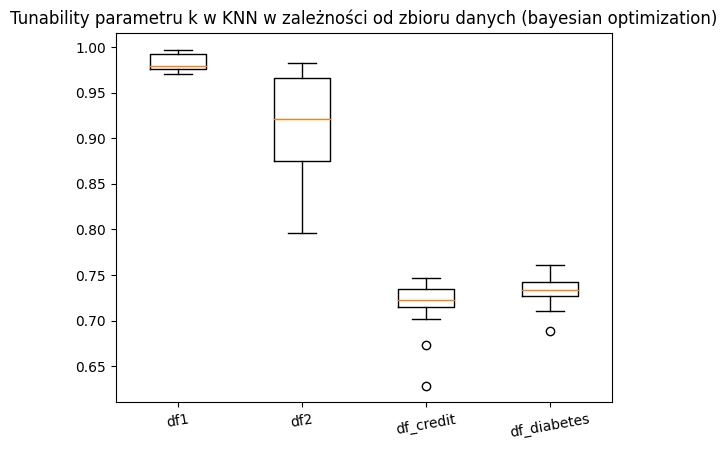

In [236]:
plt.boxplot([df_params_knn['df1'],
             df_params_knn['df2'],
             df_params_knn['df3'], 
             df_params_knn['df4']],
             labels=['df1', 'df2', 'df_credit', 'df_diabetes'],
             autorange=True)
plt.xticks(rotation = 10)
plt.title('Tunability parametru k w KNN w zależności od zbioru danych (random search)')
plt.show()

In [235]:
df_params_knn

,n_neighbors,df1,df2,df3,df4,mean_score
0,1,0.994843,0.814713,0.71500,0.688710,0.803316
1,2,0.997423,0.796377,0.62875,0.726309,0.787215
2,3,0.996133,0.889064,0.70125,0.713406,0.824963
3,4,0.994206,0.916473,0.67375,0.745981,0.832602
4,5,0.994847,0.925615,0.71875,0.733157,0.843092
5,6,0.992920,0.937406,0.70250,0.744209,0.844259
6,7,0.992903,0.953008,0.72250,0.729640,0.849513
7,8,0.994847,0.971292,0.72000,0.710074,0.849053
8,9,0.990972,0.964679,0.71625,0.732946,0.851212
9,10,0.987122,0.975154,0.71625,0.729561,0.852022


### Bayesian optimization

In [224]:
bayes_opt_knn = pd.DataFrame(columns = ['n_neighbors', 'df', 'best_score'])
bayes_optimizer_knn = {}
df_names = {1:'df_1', 2:'df_2', 3:'df_credit', 4:'df_diabetes'}
for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
  y = dataset['class']
  X = dataset.drop('class', axis=1)

  X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

  # To compare with random search
  num_pipeline = Pipeline(steps=[
  ('impute', SimpleImputer(strategy='mean')),
  ('scale',MinMaxScaler())])

  cat_pipeline = Pipeline(steps=[
      ('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
  ])

  col_trans = ColumnTransformer(transformers=[
  ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
  ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
  ],
  remainder='drop',
  n_jobs=-1)

  X_trans = col_trans.fit_transform(X_train)
  X_test_trans = col_trans.transform(X_test)
  # for column in dataset.select_dtypes(include=['category', 'object']):
  if y_train.dtype in ['category', 'object']:
    df_dict={}
    for j, e in enumerate(sorted(y_train.unique())):
      df_dict[e] = j
    y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
    y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
  else:
    y_trans = y_train
    y_test_trans = y_test

  opt = BayesSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': (1, 50)
    },
    n_iter=50,
    cv=5
  )
  opt.fit(X_trans, y_trans)
  bayes_optimizer_knn[f'df{i+1}'] = np.maximum.accumulate(opt.cv_results_['mean_test_score'])
  row = opt._optim_results[0].get('x')
  row.append(df_names[i+1])
  row.append(opt.best_score_)
  row = pd.DataFrame(row).transpose()
  row.columns = ['n_neighbors', 'df', 'best_score']
  bayes_opt_knn = pd.concat([bayes_opt_knn, row], ignore_index=True)

c:\Users\kaspr\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\kaspr\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\kaspr\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\kaspr\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\kaspr\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\opt

In [148]:
with open('bayes_optimizer_knn.pkl', 'wb') as fp:
    pickle.dump(bayes_optimizer_knn, fp)

In [164]:
with open('bayes_optimizer_knn.pkl', 'rb') as fp:
    bayes_optimizer_knn = pickle.load(fp)
df_params_knn = pd.read_csv('df_params_knn.csv')

In [225]:
bayes_opt_knn.to_csv('bayes_opt_knn.csv', index=False)

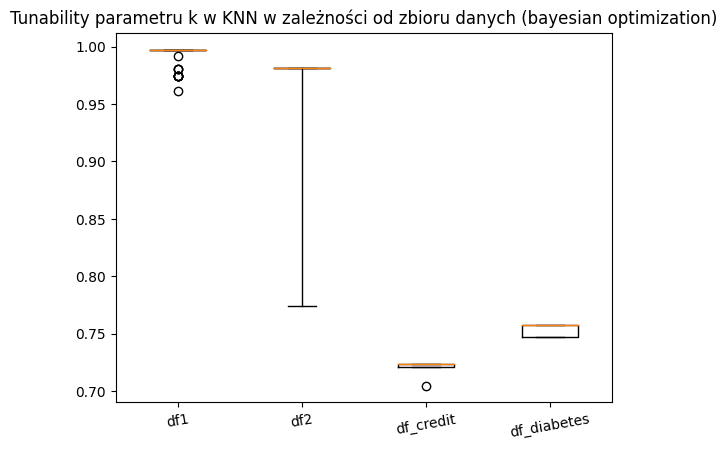

In [234]:
plt.boxplot([bayes_optimizer_knn['df1'],
             bayes_optimizer_knn['df2'],
             bayes_optimizer_knn['df3'], 
             bayes_optimizer_knn['df4']],
             labels=['df1', 'df2', 'df_credit', 'df_diabetes'],
             autorange=True)
plt.xticks(rotation = 10)
plt.title('Tunability parametru k w KNN w zależności od zbioru danych (bayesian optimization)')
plt.show()

Random search accuracy = 1.00
Bayesian optimization accuracy = 1.00


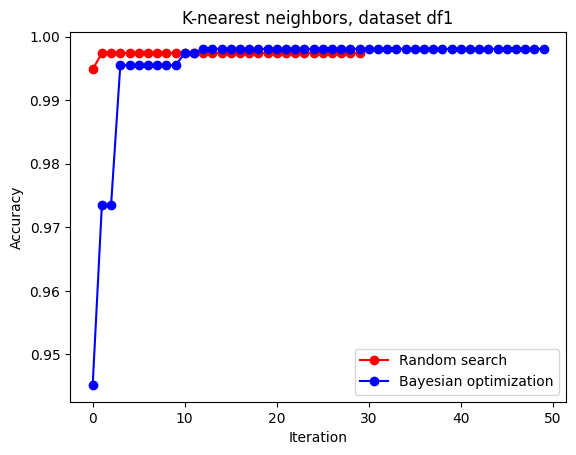

In [166]:
y_rs = np.maximum.accumulate(df_params_knn['df1']).ravel()
y_bo = bayes_optimizer_knn.get('df1')
print(f'Random search accuracy = {y_rs[-1]:.2f}')
print(f'Bayesian optimization accuracy = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
# plt.ylim(-5000, -3000)
plt.title('K-nearest neighbors, dataset df1')
plt.legend()

Random search accuracy = 0.98
Bayesian optimization accuracy = 0.98


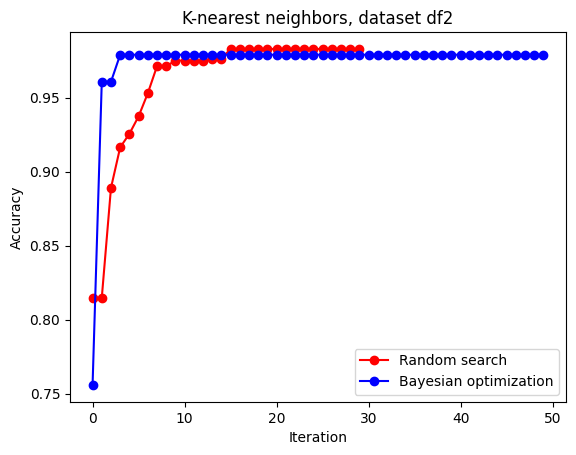

In [167]:
y_rs = np.maximum.accumulate(df_params_knn['df2']).ravel()
y_bo = bayes_optimizer_knn.get('df2')
print(f'Random search accuracy = {y_rs[-1]:.2f}')
print(f'Bayesian optimization accuracy = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
# plt.ylim(-5000, -3000)
plt.title('K-nearest neighbors, dataset df2')
plt.legend()

Random search accuracy = 0.75
Bayesian optimization accuracy = 0.72


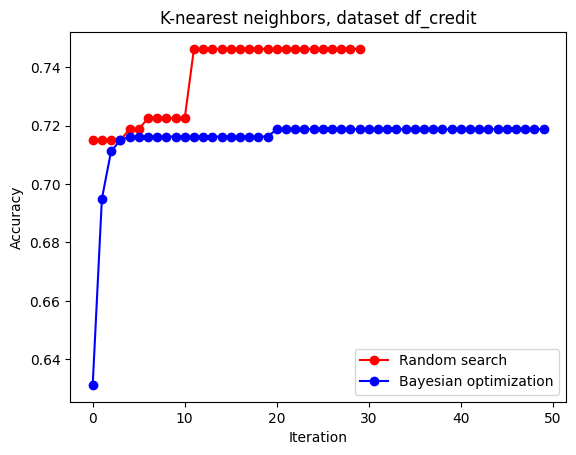

In [168]:
y_rs = np.maximum.accumulate(df_params_knn['df3']).ravel()
y_bo = bayes_optimizer_knn.get('df3')
print(f'Random search accuracy = {y_rs[-1]:.2f}')
print(f'Bayesian optimization accuracy = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
# plt.ylim(-5000, -3000)
plt.title('K-nearest neighbors, dataset df_credit')
plt.legend()

Random search accuracy = 0.76
Bayesian optimization accuracy = 0.78


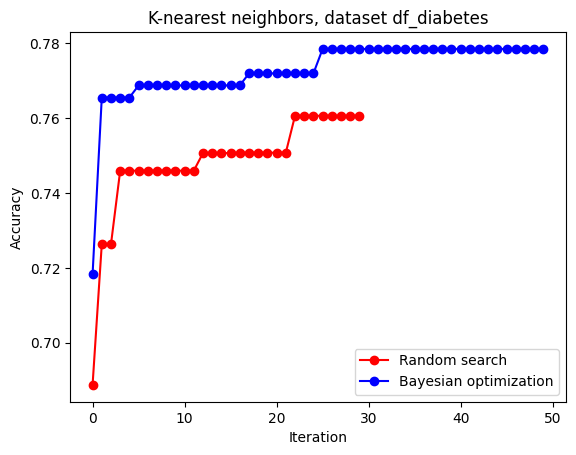

In [169]:
y_rs = np.maximum.accumulate(df_params_knn['df4']).ravel()
y_bo = bayes_optimizer_knn.get('df4')
print(f'Random search accuracy = {y_rs[-1]:.2f}')
print(f'Bayesian optimization accuracy = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
# plt.ylim(-5000, -3000)
plt.title('K-nearest neighbors, dataset df_diabetes')
plt.legend()

### Tunability calculation

In [171]:
best_scores_n_neigbors = {
    'df1' : float(max(df_params_knn.loc[df_params_knn.df1 == max(df_params_knn.df1)]['df1'])),
    'df2' : float(df_params_knn.loc[df_params_knn.df2 == max(df_params_knn.df2)]['df2']),
    'df3' : float(df_params_knn.loc[df_params_knn.df3 == max(df_params_knn.df3)]['df3']),
    'df4' : float(df_params_knn.loc[df_params_knn.df4 == max(df_params_knn.df4)]['df4']),
}

In [172]:
best_scores_default_knn = {
    'df1' : float(max(df_params_knn.loc[df_params_knn.mean_score == max(df_params_knn.mean_score)]['df1'])),
    'df2' : float(df_params_knn.loc[df_params_knn.mean_score == max(df_params_knn.mean_score)]['df2']),
    'df3' : float(df_params_knn.loc[df_params_knn.mean_score == max(df_params_knn.mean_score)]['df3']),
    'df4' : float(df_params_knn.loc[df_params_knn.mean_score == max(df_params_knn.mean_score)]['df4']),
}

In [173]:
scores_knn_bo = {
    'df1' : bayes_optimizer_knn.get('df1')[-1],
    'df2' : bayes_optimizer_knn.get('df2')[-1],
    'df3' : bayes_optimizer_knn.get('df3')[-1],
    'df4' : bayes_optimizer_knn.get('df4')[-1],
}

In [174]:
calc_tunability(best_scores_n_neigbors, best_scores_default_knn)

0.010408509776403813

In [175]:
calc_tunability(best_scores_n_neigbors, scores_knn_bo)

0.0032262368821645016

## Random forest

### Random search

In [9]:
df_params_rf = pd.DataFrame(columns = ['n_estimators', 'min_samples_leaf', 'min_samples_split', 'df1', 'df2', 'df3', 'df4' ])
for i in range(100): #this algorithm has been running substantially slower than the previous once, hence fewer iterations
  params_rf = {"n_estimators" : random.randint(1, 2000), "min_samples_leaf": random.random(), "min_samples_split": random.random()}
  iter_params = [params_rf.get('n_estimators'), params_rf.get("min_samples_leaf"), params_rf.get("min_samples_split")]

  num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())])

  cat_pipeline = Pipeline(steps=[
      ('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
  ])

  col_trans = ColumnTransformer(transformers=[
  ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
  ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
  ],
  remainder='drop',
  n_jobs=-1)

  mean_accuracies = []
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    estimator = RandomForestClassifier(n_estimators = iter_params[0],
                                       min_samples_leaf = math.ceil(iter_params[1] * len(dataset.columns)),
                                       min_samples_split = math.ceil(len(dataset) ** iter_params[2]))
    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
    else:
      y_trans = y_train
      y_test_trans = y_test

    kf = KFold(n_splits=5)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params_rf['df1'] = mean_accuracies[0]
  params_rf['df2'] = mean_accuracies[1]
  params_rf['df3'] = mean_accuracies[2]
  params_rf['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params_rf])
  df_params_rf = pd.concat([df_params_rf, row], ignore_index=True)
  df_params_rf['mean_score'] = (df_params_rf['df1'] + df_params_rf['df2'] + df_params_rf['df3'] + df_params_rf['df4']) / 4

In [21]:
# df_params_rf.to_csv('df_params_rf.csv', index=False)

In [176]:
df_params_rf = pd.read_csv('df_params_rf.csv')

,n_estimators,min_samples_leaf,min_samples_split,df1,df2,df3,df4,mean_score
0,325,0.349490,0.709213,0.478091,0.349890,0.356250,0.382734,0.391741
1,704,0.524101,0.153882,0.482934,0.435354,0.361250,0.383600,0.415784
2,649,0.477846,0.209593,0.487114,0.446460,0.364375,0.380268,0.419554
3,648,0.729253,0.814727,0.411710,0.329632,0.355625,0.359110,0.364019
4,1567,0.216428,0.158566,0.491623,0.470626,0.370000,0.381934,0.428546
...,...,...,...,...,...,...,...,...
95,1427,0.825726,0.521177,0.475513,0.393591,0.358750,0.382727,0.402645
96,200,0.079005,0.368893,0.493879,0.441291,0.379375,0.381114,0.423915
97,729,0.045423,0.064423,0.493232,0.489555,0.375000,0.381134,0.434730
98,800,0.146226,0.526119,0.491622,0.392271,0.368125,0.384380,0.409100


In [177]:
best_params_rf = {
    'n_estimators' : float(df_params_rf.loc[df_params_rf.mean_score == max(df_params_rf.mean_score)]['n_estimators']),
    'min_samples_leaf' : float(df_params_rf.loc[df_params_rf.mean_score == max(df_params_rf.mean_score)]['min_samples_leaf']),
    'min_samples_split' : float(df_params_rf.loc[df_params_rf.mean_score == max(df_params_rf.mean_score)]['min_samples_split']),
    'mean_score' : float(df_params_rf.loc[df_params_rf.mean_score == max(df_params_rf.mean_score)]['mean_score']),
}

In [178]:
best_params_rf

{'n_estimators': 729.0,
 'min_samples_leaf': 0.045422561458058675,
 'min_samples_split': 0.06442274276569449,
 'mean_score': 0.43473036471992454}

### Bayesian optimization

In [48]:
bayes_opt_rf = pd.DataFrame(columns = ['n_estimators', 'min_samples_leaf', 'min_samples_split', 'df', 'best_score'])
bayes_optimizer_rf = {}
df_names = {1:'df_1', 2:'df_2', 3:'df_credit', 4:'df_diabetes'}
for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
  y = dataset['class']
  X = dataset.drop('class', axis=1)

  X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

  # To compare with random search
  num_pipeline = Pipeline(steps=[
  ('impute', SimpleImputer(strategy='mean')),
  ('scale',MinMaxScaler())])

  cat_pipeline = Pipeline(steps=[
      ('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
  ])

  col_trans = ColumnTransformer(transformers=[
  ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
  ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
  ],
  remainder='drop',
  n_jobs=-1)

  X_trans = col_trans.fit_transform(X_train)
  X_test_trans = col_trans.transform(X_test)
  # for column in dataset.select_dtypes(include=['category', 'object']):
  if y_train.dtype in ['category', 'object']:
    df_dict={}
    for j, e in enumerate(sorted(y_train.unique())):
      df_dict[e] = j
    y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
    y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
  else:
    y_trans = y_train
    y_test_trans = y_test

  n = len(dataset)
  p = len(dataset.columns)

  opt = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators': (1, 50),
        'min_samples_leaf': (1, p),
        'min_samples_split': (2, n)
    },
    n_iter=50,
    cv=5
  )
  opt.fit(X_trans, y_trans)
  bayes_optimizer_rf[f'df{i+1}'] = np.maximum.accumulate(opt.cv_results_['mean_test_score'])
  row = opt._optim_results[0].get('x')
  row.append(df_names[i+1])
  row.append(opt.best_score_)
  row = pd.DataFrame(row).transpose()
  row.columns = ['n_estimators', 'min_samples_leaf', 'min_samples_split', 'df', 'best_score']
  bayes_opt_rf = pd.concat([bayes_opt_rf, row], ignore_index=True)

c:\Users\kaspr\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\kaspr\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\kaspr\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\kaspr\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\kaspr\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\opt

### Tunability calculation

#### Random search

In [24]:
df_params_rf_n_est = pd.DataFrame(columns = ['n_estimators', 'min_samples_leaf', 'min_samples_split', 'df1', 'df2', 'df3', 'df4' ])
for i in range(50):
  params_rf_n_est = {"n_estimators" : random.randint(1, 2000), "min_samples_leaf": best_params_rf.get('min_samples_leaf'), "min_samples_split": best_params_rf.get('min_samples_split')}
  iter_params = [params_rf_n_est.get('n_estimators'), params_rf_n_est.get("min_samples_leaf"), params_rf_n_est.get("min_samples_split")]

  num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())])

  cat_pipeline = Pipeline(steps=[
      ('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
  ])

  col_trans = ColumnTransformer(transformers=[
  ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
  ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
  ],
  remainder='drop',
  n_jobs=-1)

  mean_accuracies = []
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    estimator = RandomForestClassifier(n_estimators = iter_params[0],
                                       min_samples_leaf = math.ceil(iter_params[1] * len(dataset.columns)),
                                       min_samples_split = math.ceil(len(dataset) ** iter_params[2]))
    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
    else:
      y_trans = y_train
      y_test_trans = y_test
    kf = KFold(n_splits=5)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params_rf_n_est['df1'] = mean_accuracies[0]
  params_rf_n_est['df2'] = mean_accuracies[1]
  params_rf_n_est['df3'] = mean_accuracies[2]
  params_rf_n_est['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params_rf_n_est])
  df_params_rf_n_est = pd.concat([df_params_rf_n_est, row], ignore_index=True)
  df_params_rf_n_est['mean_score'] = (df_params_rf_n_est['df1'] + df_params_rf_n_est['df2'] + df_params_rf_n_est['df3'] + df_params_rf_n_est['df4']) / 4

In [25]:
# df_params_rf_n_est.to_csv('df_params_rf_n_est.csv')

In [39]:
df_params_rf_msl = pd.DataFrame(columns = ['n_estimators', 'min_samples_leaf', 'min_samples_split', 'df1', 'df2', 'df3', 'df4' ])
for i in range(50):
  params_rf_msl = {"n_estimators" : best_params_rf.get('n_estimators'), "min_samples_leaf": random.random(), "min_samples_split": best_params_rf.get('min_samples_split')}
  iter_params = [params_rf_msl.get('n_estimators'), params_rf_msl.get('min_samples_leaf'), params_rf_msl.get("min_samples_split")]
  num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())])

  cat_pipeline = Pipeline(steps=[
      ('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
  ])

  col_trans = ColumnTransformer(transformers=[
  ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
  ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
  ],
  remainder='drop',
  n_jobs=-1)

  mean_accuracies = []
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    estimator = RandomForestClassifier(n_estimators = int(iter_params[0]),
                                       min_samples_leaf = math.ceil(iter_params[1] * len(dataset.columns)),
                                       min_samples_split = math.ceil(len(dataset) ** iter_params[2]))
    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
    else:
      y_trans = y_train
      y_test_trans = y_test

    kf = KFold(n_splits=5)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params_rf_msl['df1'] = mean_accuracies[0]
  params_rf_msl['df2'] = mean_accuracies[1]
  params_rf_msl['df3'] = mean_accuracies[2]
  params_rf_msl['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params_rf_msl])
  df_params_rf_msl = pd.concat([df_params_rf_msl, row], ignore_index=True)
  df_params_rf_msl['mean_score'] = (df_params_rf_msl['df1'] + df_params_rf_msl['df2'] + df_params_rf_msl['df3'] + df_params_rf_msl['df4']) / 4

In [40]:
# df_params_rf_msl.to_csv('df_params_rf_msl.csv')

In [42]:
df_params_rf_mss = pd.DataFrame(columns = ['n_estimators', 'min_samples_leaf', 'min_samples_split', 'df1', 'df2', 'df3', 'df4' ])
for i in range(50):
  params_rf_mss = {"n_estimators" : best_params_rf.get('n_estimators'), "min_samples_leaf": best_params_rf.get('min_samples_leaf'), "min_samples_split": random.random()}
  iter_params = [params_rf_mss.get('n_estimators'), params_rf_mss.get("min_samples_leaf"), params_rf_mss.get("min_samples_split")]

  num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())])

  cat_pipeline = Pipeline(steps=[
      ('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
  ])

  col_trans = ColumnTransformer(transformers=[
  ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
  ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_))
  ],
  remainder='drop',
  n_jobs=-1)

  mean_accuracies = []
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    estimator = RandomForestClassifier(n_estimators = int(iter_params[0]),
                                       min_samples_leaf = math.ceil(iter_params[1] * len(dataset.columns)),
                                       min_samples_split = math.ceil(len(dataset) ** iter_params[2]))
    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
    else:
      y_trans = y_train
      y_test_trans = y_test
    kf = KFold(n_splits=5)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params_rf_mss['df1'] = mean_accuracies[0]
  params_rf_mss['df2'] = mean_accuracies[1]
  params_rf_mss['df3'] = mean_accuracies[2]
  params_rf_mss['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params_rf_mss])
  df_params_rf_mss = pd.concat([df_params_rf_mss, row], ignore_index=True)
  df_params_rf_mss['mean_score'] = (df_params_rf_mss['df1'] + df_params_rf_mss['df2'] + df_params_rf_mss['df3'] + df_params_rf_mss['df4']) / 4

In [43]:
# df_params_rf_mss.to_csv('df_params_rf_mss.csv')

In [49]:
# bayes_opt_rf.to_csv('bayes_opt_rf.csv', index=False)

In [50]:
# with open('bayes_optimizer_rf.pkl', 'wb') as fp:
#     pickle.dump(bayes_optimizer_rf, fp)

In [179]:
with open('bayes_optimizer_rf.pkl', 'rb') as fp:
    bayes_optimizer_rf = pickle.load(fp)

In [186]:
bayes_opt_rf

,n_estimators,min_samples_leaf,min_samples_split,df,best_score
0,1,2,50,df_1,0.994847
1,1,2,50,df_2,0.980418
2,3,2,50,df_credit,0.75125
3,9,66,40,df_diabetes,0.780128


#### Bayesian optimization

In [195]:
bayes_opt_rf[bayes_opt_rf['df'] == df_names[1]]['min_samples_leaf'][0]

2

In [198]:
df_params_rf_n_est_bo = pd.DataFrame(columns = ['n_estimators', 'min_samples_leaf', 'min_samples_split', 'df1', 'df2', 'df3', 'df4' ])
df_names = {1:'df_1', 2:'df_2', 3:'df_credit', 4:'df_diabetes'}
for n in range(30):
  num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())])

  cat_pipeline = Pipeline(steps=[
      ('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
  ])

  col_trans = ColumnTransformer(transformers=[
  ('num_pipeline', num_pipeline, make_column_selector( dtype_include= np.number)),
  ('cat_pipeline', cat_pipeline,make_column_selector( dtype_include= np.object_))
  ],
  remainder='drop',
  n_jobs=-1)

  mean_accuracies = []
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    params_rf_n_est_bo = {"n_estimators" : random.randint(1, 2000), 
                          "min_samples_leaf": bayes_opt_rf[bayes_opt_rf['df'] == df_names[i+1]]['min_samples_leaf'][i], 
                          "min_samples_split": bayes_opt_rf[bayes_opt_rf['df'] == df_names[i+1]]['min_samples_split'][i]}
    iter_params = [params_rf_n_est_bo.get('n_estimators'), 
                  params_rf_n_est_bo.get("min_samples_leaf"), 
                  params_rf_n_est_bo.get("min_samples_split")]

    estimator = RandomForestClassifier(n_estimators = iter_params[0],
                                       min_samples_leaf = iter_params[1],
                                       min_samples_split = iter_params[2])
    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
    else:
      y_trans = y_train
      y_test_trans = y_test
    kf = KFold(n_splits=5)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params_rf_n_est_bo['df1'] = mean_accuracies[0]
  params_rf_n_est_bo['df2'] = mean_accuracies[1]
  params_rf_n_est_bo['df3'] = mean_accuracies[2]
  params_rf_n_est_bo['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params_rf_n_est_bo])
  df_params_rf_n_est_bo = pd.concat([df_params_rf_n_est_bo, row], ignore_index=True)
  df_params_rf_n_est_bo['mean_score'] = (df_params_rf_n_est_bo['df1'] + df_params_rf_n_est_bo['df2'] + df_params_rf_n_est_bo['df3'] + df_params_rf_n_est_bo['df4']) / 4

In [199]:
df_params_rf_msl_bo = pd.DataFrame(columns = ['n_estimators', 'min_samples_leaf', 'min_samples_split', 'df1', 'df2', 'df3', 'df4' ])
df_names = {1:'df_1', 2:'df_2', 3:'df_credit', 4:'df_diabetes'}
for n in range(30):
  num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())])

  cat_pipeline = Pipeline(steps=[
      ('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
  ])

  col_trans = ColumnTransformer(transformers=[
  ('num_pipeline', num_pipeline, make_column_selector( dtype_include= np.number)),
  ('cat_pipeline', cat_pipeline,make_column_selector( dtype_include= np.object_))
  ],
  remainder='drop',
  n_jobs=-1)

  mean_accuracies = []
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    params_rf_msl_bo = {"n_estimators" : bayes_opt_rf[bayes_opt_rf['df'] == df_names[i+1]]['n_estimators'][i], 
                          "min_samples_leaf": random.randint(1, len(dataset.columns)), 
                          "min_samples_split": bayes_opt_rf[bayes_opt_rf['df'] == df_names[i+1]]['min_samples_split'][i]}
    iter_params = [params_rf_msl_bo.get('n_estimators'), 
                  params_rf_msl_bo.get("min_samples_leaf"), 
                  params_rf_msl_bo.get("min_samples_split")]

    estimator = RandomForestClassifier(n_estimators = iter_params[0],
                                       min_samples_leaf = iter_params[1],
                                       min_samples_split = iter_params[2])
    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
    else:
      y_trans = y_train
      y_test_trans = y_test
    kf = KFold(n_splits=5)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params_rf_msl_bo['df1'] = mean_accuracies[0]
  params_rf_msl_bo['df2'] = mean_accuracies[1]
  params_rf_msl_bo['df3'] = mean_accuracies[2]
  params_rf_msl_bo['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params_rf_msl_bo])
  df_params_rf_msl_bo = pd.concat([df_params_rf_msl_bo, row], ignore_index=True)
  df_params_rf_msl_bo['mean_score'] = (df_params_rf_msl_bo['df1'] + df_params_rf_msl_bo['df2'] + df_params_rf_msl_bo['df3'] + df_params_rf_msl_bo['df4']) / 4

In [200]:
df_params_rf_mss_bo = pd.DataFrame(columns = ['n_estimators', 'min_samples_leaf', 'min_samples_split', 'df1', 'df2', 'df3', 'df4' ])
df_names = {1:'df_1', 2:'df_2', 3:'df_credit', 4:'df_diabetes'}
for n in range(30):
  num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())])

  cat_pipeline = Pipeline(steps=[
      ('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
  ])

  col_trans = ColumnTransformer(transformers=[
  ('num_pipeline', num_pipeline, make_column_selector( dtype_include= np.number)),
  ('cat_pipeline', cat_pipeline,make_column_selector( dtype_include= np.object_))
  ],
  remainder='drop',
  n_jobs=-1)

  mean_accuracies = []
  for i, dataset in enumerate([df_1, df_2, df_credit, df_diabetes]):
    params_rf_mss_bo = {"n_estimators" : bayes_opt_rf[bayes_opt_rf['df'] == df_names[i+1]]['n_estimators'][i], 
                          "min_samples_leaf": bayes_opt_rf[bayes_opt_rf['df'] == df_names[i+1]]['min_samples_leaf'][i], 
                          "min_samples_split": random.randint(2, len(dataset))}
    iter_params = [params_rf_mss_bo.get('n_estimators'), 
                  params_rf_mss_bo.get("min_samples_leaf"), 
                  params_rf_mss_bo.get("min_samples_split")]

    estimator = RandomForestClassifier(n_estimators = iter_params[0],
                                       min_samples_leaf = iter_params[1],
                                       min_samples_split = iter_params[2])
    y = dataset['class']
    X = dataset.drop('class', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

    X_trans = col_trans.fit_transform(X_train)
    X_test_trains = col_trans.transform(X_test)
    if y_train.dtype in ['category', 'object']:
      df_dict={}
      for j, e in enumerate(sorted(y_train.unique())):
        df_dict[e] = j
      y_trans = y_train.map(lambda s: df_dict.get(s) if s in df_dict else s)
      y_test_trans = y_test.map(lambda s: df_dict.get(s) if s in df_dict else s)
    else:
      y_trans = y_train
      y_test_trans = y_test
    kf = KFold(n_splits=5)
    accuracy = 0
    for train_index, test_index in kf.split(X_trans):
      y_train, y_test = np.take(y_trans, train_index), np.take(y_trans, test_index)
      X_train, X_test = X_trans[train_index, :], X_trans[test_index, :]
      estimator.fit(X_train, y_train)
      y_pred = estimator.predict(X_test)
      accuracy += metrics.accuracy_score(y_test, y_pred)
    mean_accuracy = accuracy/10
    mean_accuracies.append(mean_accuracy)
  params_rf_mss_bo['df1'] = mean_accuracies[0]
  params_rf_mss_bo['df2'] = mean_accuracies[1]
  params_rf_mss_bo['df3'] = mean_accuracies[2]
  params_rf_mss_bo['df4'] = mean_accuracies[3]

  row = pd.DataFrame([params_rf_mss_bo])
  df_params_rf_mss_bo = pd.concat([df_params_rf_mss_bo, row], ignore_index=True)
  df_params_rf_mss_bo['mean_score'] = (df_params_rf_mss_bo['df1'] + df_params_rf_mss_bo['df2'] + df_params_rf_mss_bo['df3'] + df_params_rf_mss_bo['df4']) / 4

Random search accuracy = 0.50
Bayesian optimization accuracy = 0.99


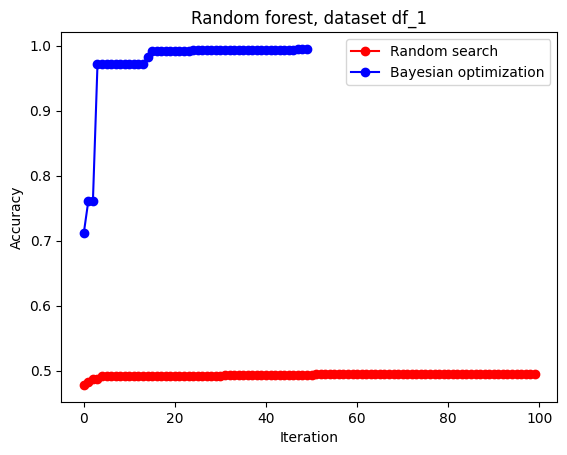

In [181]:
y_rs = np.maximum.accumulate(df_params_rf['df1']).ravel()
y_bo = bayes_optimizer_rf.get('df1')
print(f'Random search accuracy = {y_rs[-1]:.2f}')
print(f'Bayesian optimization accuracy = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
# plt.ylim(-5000, -3000)
plt.title('Random forest, dataset df_1')
plt.legend()

Random search accuracy = 0.49
Bayesian optimization accuracy = 0.98


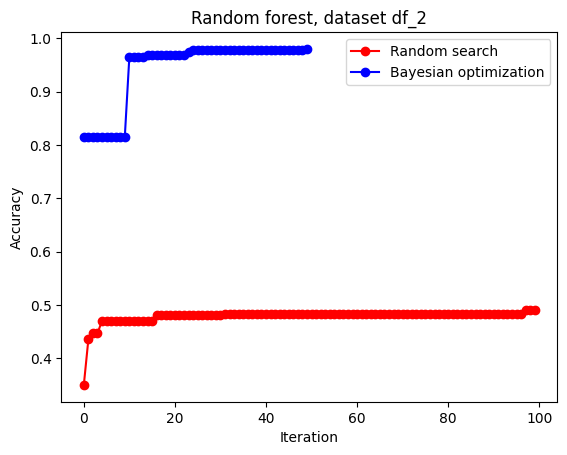

In [182]:
y_rs = np.maximum.accumulate(df_params_rf['df2']).ravel()
y_bo = bayes_optimizer_rf.get('df2')
print(f'Random search accuracy = {y_rs[-1]:.2f}')
print(f'Bayesian optimization accuracy = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
# plt.ylim(-5000, -3000)
plt.title('Random forest, dataset df_2')
plt.legend()

Random search accuracy = 0.38
Bayesian optimization accuracy = 0.75


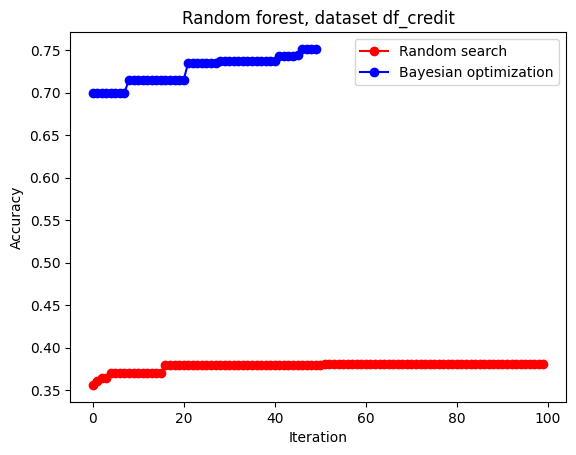

In [183]:
y_rs = np.maximum.accumulate(df_params_rf['df3']).ravel()
y_bo = bayes_optimizer_rf.get('df3')
print(f'Random search accuracy = {y_rs[-1]:.2f}')
print(f'Bayesian optimization accuracy = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
# plt.ylim(-5000, -3000)
plt.title('Random forest, dataset df_credit')
plt.legend()

Random search accuracy = 0.40
Bayesian optimization accuracy = 0.78


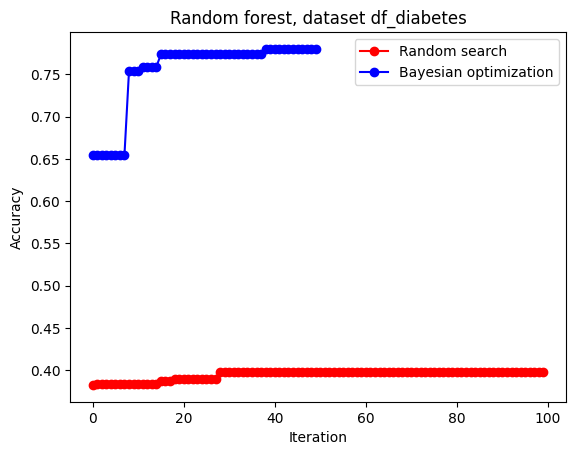

In [184]:
y_rs = np.maximum.accumulate(df_params_rf['df4']).ravel()
y_bo = bayes_optimizer_rf.get('df4')
print(f'Random search accuracy = {y_rs[-1]:.2f}')
print(f'Bayesian optimization accuracy = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
# plt.ylim(-5000, -3000)
plt.title('Random forest, dataset df_diabetes')
plt.legend()

#### Calculating tunability

##### Random search

In [58]:
best_scores_default_rf = {
    'df1' : float(max(df_params_rf.loc[df_params_rf.mean_score == max(df_params_rf.mean_score)]['df1'])),
    'df2' : float(df_params_rf.loc[df_params_rf.mean_score == max(df_params_rf.mean_score)]['df2']),
    'df3' : float(df_params_rf.loc[df_params_rf.mean_score == max(df_params_rf.mean_score)]['df3']),
    'df4' : float(df_params_rf.loc[df_params_rf.mean_score == max(df_params_rf.mean_score)]['df4']),
}

In [61]:
best_scores_rf_n_estimators = {
    'df1' : float(max(df_params_rf_n_est.loc[df_params_rf_n_est.df1 == max(df_params_rf_n_est.df1)]['df1'])),
    'df2' : float(df_params_rf_n_est.loc[df_params_rf_n_est.df2 == max(df_params_rf_n_est.df2)]['df2']),
    'df3' : float(df_params_rf_n_est.loc[df_params_rf_n_est.df3 == max(df_params_rf_n_est.df3)]['df3']),
    'df4' : float(df_params_rf_n_est.loc[df_params_rf_n_est.df4 == max(df_params_rf_n_est.df4)]['df4']),
}

best_scores_rf_min_samples_leaf = {
    'df1' : float(max(df_params_rf_msl.loc[df_params_rf_msl.df1 == max(df_params_rf_msl.df1)]['df1'])),
    'df2' : float(df_params_rf_msl.loc[df_params_rf_msl.df2 == max(df_params_rf_msl.df2)]['df2']),
    'df3' : float(df_params_rf_msl.loc[df_params_rf_msl.df3 == max(df_params_rf_msl.df3)]['df3']),
    'df4' : float(df_params_rf_msl.loc[df_params_rf_msl.df4 == max(df_params_rf_msl.df4)]['df4']),
}

best_scores_rf_min_samples_split = {
    'df1' : float(max(df_params_rf_mss.loc[df_params_rf_mss.df1 == max(df_params_rf_mss.df1)]['df1'])),
    'df2' : float(df_params_rf_mss.loc[df_params_rf_mss.df2 == max(df_params_rf_mss.df2)]['df2']),
    'df3' : float(df_params_rf_mss.loc[df_params_rf_mss.df3 == max(df_params_rf_mss.df3)]['df3']),
    'df4' : float(df_params_rf_mss.loc[df_params_rf_mss.df4 == max(df_params_rf_mss.df4)]['df4']),
}

In [59]:
scores_bo_rf = {
    'df1' : bayes_optimizer_rf.get('df1')[-1],
    'df2' : bayes_optimizer_rf.get('df2')[-1],
    'df3' : bayes_optimizer_rf.get('df3')[-1],
    'df4' : bayes_optimizer_rf.get('df4')[-1],
}

In [239]:
df_params_rf_n_est_bo.head(5)

,n_estimators,min_samples_leaf,min_samples_split,df1,df2,df3,df4,mean_score
0,1785,66,40,0.493558,0.387743,0.369375,0.370518,0.405299
1,1984,66,40,0.493880,0.394916,0.366875,0.359123,0.403698
2,1753,66,40,0.492908,0.383821,0.368125,0.368879,0.403433
3,259,66,40,0.494202,0.389691,0.358125,0.373764,0.403945
4,571,66,40,0.493235,0.392276,0.365000,0.368093,0.404651


In [251]:
best_score_bo_n_est = {
    'df1': df_params_rf_n_est_bo[df_params_rf_n_est_bo['df1'] == max(df_params_rf_n_est_bo['df1'])]['df1'].values[0],
    'df2': df_params_rf_n_est_bo[df_params_rf_n_est_bo['df2'] == max(df_params_rf_n_est_bo['df2'])]['df2'].values[0],
    'df3': df_params_rf_n_est_bo[df_params_rf_n_est_bo['df3'] == max(df_params_rf_n_est_bo['df3'])]['df3'].values[0],
    'df4': df_params_rf_n_est_bo[df_params_rf_n_est_bo['df4'] == max(df_params_rf_n_est_bo['df4'])]['df4'].values[0],
}

In [255]:
best_score_bo_min_samples_leaf = {
    'df1': df_params_rf_msl_bo[df_params_rf_msl_bo['df1'] == max(df_params_rf_msl_bo['df1'])]['df1'].values[0],
    'df2': df_params_rf_msl_bo[df_params_rf_msl_bo['df2'] == max(df_params_rf_msl_bo['df2'])]['df2'].values[0],
    'df3': df_params_rf_msl_bo[df_params_rf_msl_bo['df3'] == max(df_params_rf_msl_bo['df3'])]['df3'].values[0],
    'df4': df_params_rf_msl_bo[df_params_rf_msl_bo['df4'] == max(df_params_rf_msl_bo['df4'])]['df4'].values[0],
}

In [256]:
best_score_bo_min_samples_split = {
    'df1': df_params_rf_mss_bo[df_params_rf_mss_bo['df1'] == max(df_params_rf_mss_bo['df1'])]['df1'].values[0],
    'df2': df_params_rf_mss_bo[df_params_rf_mss_bo['df2'] == max(df_params_rf_mss_bo['df2'])]['df2'].values[0],
    'df3': df_params_rf_mss_bo[df_params_rf_mss_bo['df3'] == max(df_params_rf_mss_bo['df3'])]['df3'].values[0],
    'df4': df_params_rf_mss_bo[df_params_rf_mss_bo['df4'] == max(df_params_rf_mss_bo['df4'])]['df4'].values[0],
}

In [62]:
calc_tunability(best_scores_rf_n_estimators, best_scores_default_rf)

0.009325525912549537

In [63]:
calc_tunability(best_scores_rf_min_samples_leaf, best_scores_default_rf)

0.006817214334802299

In [64]:
calc_tunability(best_scores_rf_min_samples_split, best_scores_default_rf)

0.007173714493650729

In [254]:
calc_tunability(best_score_bo_n_est, scores_bo_rf)

-0.4659667170716429

In [257]:
calc_tunability(best_score_bo_min_samples_leaf, scores_bo_rf)

-0.4826682684169246

In [258]:
calc_tunability(best_score_bo_min_samples_split, scores_bo_rf)

-0.4868478629421145

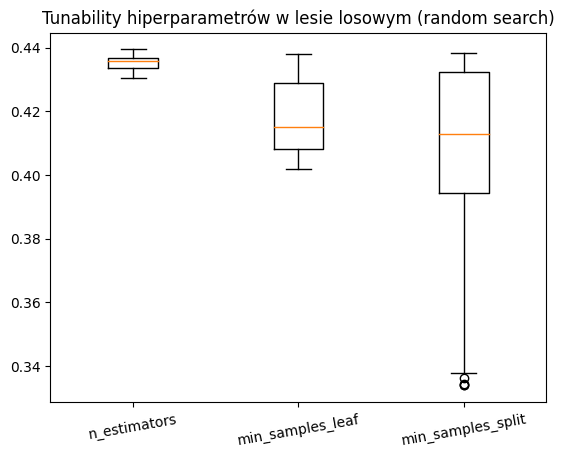

In [264]:
plt.boxplot([df_params_rf_n_est['mean_score'],
             df_params_rf_msl['mean_score'],
             df_params_rf_mss['mean_score']],
             labels=['n_estimators', 'min_samples_leaf', 'min_samples_split'],
             autorange=True)
plt.xticks(rotation = 10)
plt.title('Tunability hiperparametrów w lesie losowym (random search)')
plt.show()

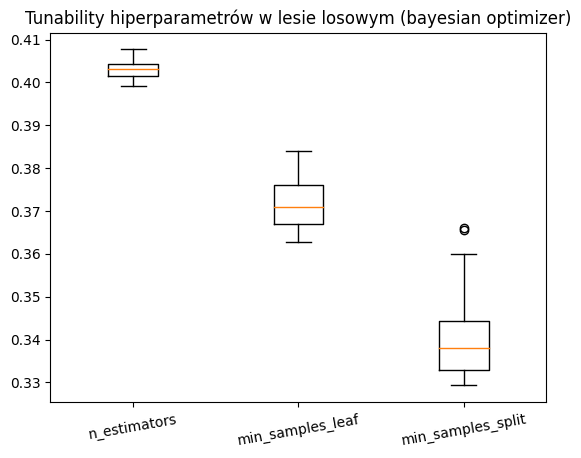

In [263]:
plt.boxplot([df_params_rf_n_est_bo['mean_score'],
             df_params_rf_msl_bo['mean_score'],
             df_params_rf_mss_bo['mean_score']],
             labels=['n_estimators', 'min_samples_leaf', 'min_samples_split'],
             autorange=True)
plt.xticks(rotation = 10)
plt.title('Tunability hiperparametrów w lesie losowym (bayesian optimizer)')
plt.show()